# MAST30034 Project 2 Group 1 Summary Notebook

## 1. Data collection

### Data sources

#### External datasets
- **ABS Census data:** Downloaded from ABS Census DataPacks - General Community Profile. As of 2021.
- **Crime data:**: Downloaded from Crime Statstics Agency - Criminal incident by LGA - Year Ending Mar 2025.
- **Population data:** Downloaded from Department of Transport and Planning. VIF2023 Victoria Demographic Projections to 2051
- **Public transport data:** Downloaded from PTV General Transit Feed Specification (GTFS) Data. As of September 2025.
- **School data:** Downloaded from Department of Education. School Locations 2024.
- **Median property prices:** Downloaded from VIC.GOV.AU Victorian Property Sales Report - Median House by Suburb Quarterly

#### Given datasets
- **Rental property listings:** Scraped from domain.com.au. As of September 2025.
- **Moving annual median rent by suburb and town:** Victoria Government Families, Fairness and Housings Rental report. As of March quarter 2025.

**Assumptions and limitations:**

The rental dataset reflects only observed/scraped listings and may not necessarily be representative of all rental properties available within Victoria.

Additionally, using several external datasets (resulting in 57 total features) may introduce potential multicollinearity between features (e.g. number of schools vs suburb population). Thus, the model may capture correlations rather than causal effects. However, we aim to address this through feature selection and feature importance.

Finally, the external datasets span different time periods—some are current (e.g., crime and transport data), while others, such as the ABS Census (last updated in 2021), are less recent. This temporal mismatch may introduce inconsistencies, as demographic or social trends could have shifted in the intervening years. Thus, we assume that the characteristics captured in older datasets remain reasonably stable over time, and any changes since collection are gradual enough not to invalidate their use in modelling current rental prices.

## 2. Dataset building

The 5 external datasets were processed and cleaned to be merged with the rental property listings dataset.

This means that for each rental listing, there will be rental specific attributes (e.g. number of bedrooms, number of schools within 2km), as well as suburb level attributes (e.g. suburb population, suburb crime index).

This gives us 57 initial attributes/features, which need to be further cleaned, processed, filtered and selected to analyse rental prices.

In [2]:
import pandas as pd
merged_dataset = pd.read_csv("../data/processed/real_estate/vic_rentals_all_enriched.csv")
merged_dataset.columns

Index(['listing_id', 'suburb', 'postcode', 'weekly_rent', 'bond',
       'available_date', 'date_listed', 'days_listed', 'bedrooms', 'bathrooms',
       'carspaces', 'property_type', 'address', 'lat', 'lon', 'photo_count',
       'video_count', 'floorplans_count', 'virtual_tour', 'primary_type',
       'secondary_type', 'agency', 'agent_names', 'land_area',
       'num_metro_bus_stops', 'num_metro_tram_stops', 'num_metro_train_stops',
       'num_regional_bus_stops', 'num_regional_train_stops', 'num_schools_2km',
       'Median_age_persons', 'Median_mortgage_repay_monthly',
       'Median_tot_prsnl_inc_weekly', 'Median_rent_weekly',
       'Median_tot_fam_inc_weekly', 'Average_num_psns_per_bedroom',
       'Median_tot_hhd_inc_weekly', 'Average_household_size',
       'Owner occupied (%)', 'Mortgage (%)', 'Total rented (%)',
       'Other tenure (%)', 'Unemployment', 'post_gradutae (%)',
       'Graduate_diploma_certificate(%)', 'Bachelor (%)',
       'Advanced_&_Diploma (%)', 'Certific

## 3. Feature Engineering

### Handling missing values

With the initial merged dataset, need to deal with any possible nan values per feature. This follows a 2 step process:

**1. Mean imputation:** We create a lookup dictionary that is grouped by the property's suburb, property_type, bedrooms, and bathrooms and impute the feature's missing value according to the mean-aggregated dictionary value. Next, we create a relaxed version of this lookup dictionary on 'property_type', 'bedrooms' and use a similar pattern to impute more nans. This is done for the "weekly_rent" and "carspaces" features, which have the among the highest missing values. 

**2. Listwise deletion:** After imputing nans, there is significantly less remaining missing values so just drop them.

Note: land_area was simply dropped and remove despite being a potential useful feature as it had too many missing values i.e 12329/12331

**Assumptions and limitations**
- Assumes features are missing at random and not systematically biased
- Mean imputation may be too simple a method for imputation so may ignore natural variance in features. Though this is aimed to be addressed through the use of lookup dictionaries.

In [2]:
def find_nans(data):
    missing_list = [(col, data[col].isnull().sum()) for col in data.columns]
    non_nans = [(col, cnt) for col, cnt in missing_list if cnt != 0]
    return sorted(non_nans, key=lambda x: x[1], reverse=True)  # sort by column name

### Outlier detection

These numerical features were considered to determine outliers: ['weekly_rent', 'bedrooms', 'bathrooms', 'carspaces', 'num_metro_bus_stops', 'num_metro_tram_stops', 'num_schools_2km', 'incidents_recorded']

We assume that extreme values are unrepresentative, which should be a valid assumption as there are only 27 rental properties above $3000, which should have little impact on model performance.

We used 3000 as the as upper limit for the rental prices of houses in the Vic-Gov website is 2885. (https://www.housing.vic.gov.au/what-does-rent-cost-victoria)

In [ ]:
data=merged_dataset
# Find how many 0 weekly_rent values there are
zero_rent_count = (data["weekly_rent"] == 0).sum()
print("Zero rent count:", zero_rent_count)

# Find how many high outlier weekly_rent values there are i.e above 3000
highoutlier_rent_count = (data["weekly_rent"] >= 3000).sum()
print("High outlier rent count:", highoutlier_rent_count)

# Find how many data points with 50 or more bedrooms
high_bedroom_count = (data["bedrooms"] >= 50).sum()
print("High bedroom count:", high_bedroom_count)

Zero rent count: 16
High outlier rent count: 26
High bedroom count: 1


Surprisingly, not many outliers were detected. Removing these outliers gives the following distribution for the numerical values:

In [ ]:
# Remove outliers rows
data = data[(data["weekly_rent"] > 0) & (data["weekly_rent"] <= 3000) & (data["bedrooms"] < 50)]
# Looking at numerical variables
data[['weekly_rent', 'bedrooms', 'bathrooms', 'carspaces', 'num_metro_bus_stops', 'num_metro_tram_stops', 'num_schools_2km', 'incidents_recorded']].describe()

,weekly_rent,bedrooms,bathrooms,carspaces,num_metro_bus_stops,num_metro_tram_stops,num_schools_2km,incidents_recorded
count,11913.000000,11913.000000,11910.000000,10264.00000,11913.000000,11913.000000,11913.000000,11913.000000
mean,622.277260,2.721061,1.588161,1.66855,62.066734,21.067237,8.073533,13273.937392
std,249.702662,1.080075,0.629483,0.93470,43.156864,35.080943,4.794813,5812.202109
min,33.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,77.000000
25%,490.000000,2.000000,1.000000,1.00000,23.000000,0.000000,4.000000,9525.000000
50%,560.000000,3.000000,2.000000,2.00000,66.000000,0.000000,8.000000,13140.500000
75%,685.000000,4.000000,2.000000,2.00000,96.000000,35.000000,12.000000,17495.333333
max,3000.000000,11.000000,12.000000,22.00000,183.000000,127.000000,23.000000,34620.000000


Finally, after encoding categorical variables (extracting time features from 'available_date'), our dataset is finally cleaned and ready to be analysed to determine important features for predicting rental prices.

## 4. Modelling Feature Importance

Models: Random Forest Regressor and XG boost were selected with their ability to capture complex relationships in data and a useful feature importance function to help understand which features are were most important in model predictions. 

### Feature Engeering And Encoding

Time data was feature engineered to hour, day and month; and then encoded using cyclic encoding to help model capture potential seasonal change in rent prices.

Frequency encoding was used for non-numerical features i.e postcode, property_type and agency. 

In [ ]:
# Feature Engineering time data
data['available_date'] = pd.to_datetime(data['available_date'], errors='coerce')
data['available_day'] = data['available_date'].dt.day
data['available_month'] = data['available_date'].dt.month   
data['available_year'] = data['available_date'].dt.year
data = data.drop(columns=['available_date'])

/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_9004/432806405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['available_date'] = pd.to_datetime(data['available_date'], errors='coerce')
/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_9004/432806405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['available_day'] = data['available_date'].dt.day
/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_9004/432806405.py:4: SettingWithCopyWarning: 
A value is trying to

In [ ]:
import numpy as np

# Encode month cyclically 
data['month_sin'] = np.sin(data['available_month'] / 12 * 2 * np.pi)
data['month_cos'] = np.cos(data['available_month'] / 12 * 2 * np.pi)
data = data.drop(columns=['available_month'])

# Encode day cyclically
data['day_sin'] = np.sin(data['available_day'] / 31 * 2 * np.pi)
data['day_cos'] = np.cos(data['available_day'] / 31 * 2 * np.pi)
data = data.drop(columns=['available_day'])

# Frequency encoding for Non-numericeal columns
post_freq = data['postcode'].value_counts(normalize=True)
data['postcode'] = data['postcode'].map(post_freq)
property_freq = data['property_type'].value_counts(normalize=True)
data['property_type'] = data['property_type'].map(property_freq)
agency_freq = data['agency'].value_counts(normalize=True)
data['agency'] = data['agency'].map(agency_freq)

#### Limitations and Assumptions

We assume that postcode, propety_type and agency have certain catergories(e.g a common postcode, popular property type,etc.) that can influence weekly rent prices when using frequency encoding.

Cycle encodinng treats months and day pattern as if patterns always repeat identically, training only on 2025 might cause bias in the predictions of data for a different year. This shouldn't be an issue however, as this data set will not be used in forcasting.

### Data leakage

Certain features in the data such as 'median_rent_weekly', 'median_morgage_repay_monthly' and 'bond' can cause data leakage and hence were removed. (bond was remove earlier in preprocessing)

In [ ]:
# Drop lat and long for modeling
data = data.drop(columns=['lat', 'lon', 'Median_rent_weekly', 'Median_mortgage_repay_monthly'])

All data was rescaled using the Standardize Scalar method

### Findings

Feature Selection was conducted using Mutual Information(MI) as we hav 42 features. 20 Features were selected from the 42.



In [ ]:
# This is code for demonstration only and will not run correctly without the full notebook code.
# Train/test split based on available_year
from sklearn.feature_selection import mutual_info_regression
data = data[data['available_year'] == 2025]

y = data['weekly_rent']
X = data.drop(columns=['weekly_rent'])

# Compute MI scores between each feature and the target variable
mi = mutual_info_regression(X, y, discrete_features="auto", random_state=0)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Select the top k features with the highest MI scores
k = 20
selected_features = mi_scores.head(k).index.tolist()

X_selection = X[selected_features]

In [ ]:
# This is the results of the code above saved as a CSV for easy loading in the summary notebook.
selected_features = pd.read_csv("../data/outputs/feature_selection_dataframe.csv")
selected_features

,Bachelor (%),Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,population_est,Certificate_level (%),incidents_recorded,post_gradutae (%),Graduate_diploma_certificate(%),Advanced_&_Diploma (%),Population-2023,Median_tot_prsnl_inc_weekly,Unemployment,crime_index,rate_per_100000_population,crime_per_person,crime_rank,Owner occupied (%),Mortgage (%),Total rented (%),Total_persons
0,0.382874,3024.0,2192.0,152460.693763,0.158769,16262.250000,0.168135,0.065559,0.119857,13408,1080.0,0.046495,1.813199,10220.714480,0.102207,137.750000,0.270928,0.327294,0.379467,8969.0
1,0.393366,2926.0,2111.0,138420.725117,0.153807,10143.000000,0.170695,0.073617,0.134493,17203,1113.0,0.038438,1.365466,7696.915003,0.076969,183.000000,0.299913,0.289420,0.385893,9889.0
2,0.458828,3113.0,2098.0,141511.437067,0.110812,19274.333333,0.164398,0.050746,0.118529,20268,1343.0,0.036782,2.245682,12658.554200,0.126586,25.333333,0.189694,0.237092,0.549360,13735.0
3,0.352016,1630.0,1278.0,190296.130450,0.093904,14568.500000,0.247296,0.020813,0.111111,14178,503.0,0.123011,1.401696,7901.140204,0.079011,189.500000,0.151699,0.176589,0.638076,6102.0
4,0.365364,1914.0,1441.0,185521.681300,0.118189,9282.000000,0.192183,0.043979,0.146189,25286,682.0,0.069917,0.887587,5003.188811,0.050032,467.000000,0.241095,0.238566,0.473175,13893.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11484,0.168563,1685.0,1477.0,417618.665300,0.396929,21416.000000,0.059695,0.023620,0.170067,13530,707.0,0.066765,0.909751,5128.123281,0.051281,439.000000,0.230983,0.404359,0.338007,9314.0
11485,0.391513,2475.0,1718.0,194580.599700,0.087128,34620.000000,0.245423,0.048634,0.092480,18017,953.0,0.070373,3.156398,17792.112910,0.177921,2.000000,0.130270,0.198541,0.639825,10651.0
11486,0.313112,1470.0,1401.0,190296.130450,0.199609,14568.500000,0.121439,0.024136,0.162318,23509,558.0,0.081065,1.401696,7901.140204,0.079011,189.500000,0.316660,0.229401,0.393775,9198.0
11487,0.391513,2475.0,1718.0,194580.599700,0.087128,34620.000000,0.245423,0.048634,0.092480,18017,953.0,0.070373,3.156398,17792.112910,0.177921,2.000000,0.130270,0.198541,0.639825,10651.0


Results below show that models without feature selection performes significantly better with average r^2 of 0.7 and average MAE of 70 compared to models with feature selection with average r^2  0.25 and average MAE of 126.5.

Cause: likely due to MI only capturing univeriate relationships between one variable vs target variable while our data contains strong multivariable interactions; hence MI fails to compare them and discards useful features.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Here we simply read in preprocess and transofrmed data for modeling for demonstration purposes. 
# Look at cleaning_and_feature_selection.ipynb for full details steps.
model_data = pd.read_csv("../data/outputs/real_estate_data.csv")
feature_select_model_data = pd.read_csv("../data/outputs/feature_selected_real_estate_data.csv")
X_train = model_data[model_data['dataset']=='train'].drop(columns=['dataset'])
y_train = X_train.pop('target')
X_test = model_data[model_data['dataset']=='test'].drop(columns=['dataset'])
y_test = X_test.pop('target')
feature_X_train = feature_select_model_data[feature_select_model_data['dataset']=='train'].drop(columns=['dataset'])
feature_y_train = feature_X_train.pop('target')
feature_X_test = feature_select_model_data[feature_select_model_data['dataset']=='test'].drop(columns=['dataset'])
feature_y_test = feature_X_test.pop('target')

# Standardize scalar, resacling all data. (can target specific columns if needed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
feature_X_train = scaler.fit_transform(feature_X_train)
feature_X_test = scaler.transform(feature_X_test)

xgboost = GradientBoostingRegressor(random_state=42)
xgboost.fit(X_train, y_train)
feature_xgboost = GradientBoostingRegressor(random_state=42)
feature_xgboost.fit(feature_X_train, feature_y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
feature_rf_model = RandomForestRegressor(random_state=42)
feature_rf_model.fit(feature_X_train, feature_y_train)

# Gradient Boosting
y_pred_gb = xgboost.predict(X_test)
gb_r2 = r2_score(y_test, y_pred_gb)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
feature_y_pred_gb = feature_xgboost.predict(feature_X_test)
feature_gb_r2 = r2_score(feature_y_test, feature_y_pred_gb)
feature_gb_mae = mean_absolute_error(feature_y_test, feature_y_pred_gb)

# Random Forest
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
feature_y_pred_rf = feature_rf_model.predict(feature_X_test)
feature_rf_r2 = r2_score(feature_y_test, feature_y_pred_rf)
feature_rf_mae = mean_absolute_error(feature_y_test, feature_y_pred_rf)

print("GradientBoosting -> R^2:", gb_r2, " MAE:", gb_mae)
print("RandomForest     -> R^2:", rf_r2, " MAE:", rf_mae)
print("Feature Selected GradientBoosting -> R^2:", feature_gb_r2, " MAE:", feature_gb_mae)
print("Feature Selected RandomForest     -> R^2:", feature_rf_r2, " MAE:", feature_rf_mae)

GradientBoosting -> R^2: 0.7186174325262387  MAE: 73.81170324329315
RandomForest     -> R^2: 0.7292647628876037  MAE: 67.96639191705792
Feature Selected GradientBoosting -> R^2: 0.2645192217151513  MAE: 126.02714754576765
Feature Selected RandomForest     -> R^2: 0.25075189877351656  MAE: 127.14904897145918


#### Model Findings
Most important and strongest indicators variables are **Bedrooms**, **Bathrooms** and **Bachelor(%)** with secondary drivers such as **education level**, **household income** and **public transport convenience**  able to provide additional context for more accurate model predictions of rental prices. 
 

In [15]:
rf_feature_importance = pd.read_csv("../data/outputs/rf_importance_features.csv")
rf_feature_importance.head(10)

,Feature,Importance(%) for Prediction
0,bathrooms,21.96
1,Bachelor (%),16.20
2,bedrooms,13.21
3,days_listed,3.66
4,Median_tot_fam_inc_weekly,2.91
5,Median_tot_prsnl_inc_weekly,2.73
6,num_metro_bus_stops,2.56
7,num_metro_tram_stops,2.55
8,agency,2.16
9,postcode,2.13


In [16]:
xgboost_feature_importance = pd.read_csv("../data/outputs/xgboost_importance_features.csv")
xgboost_feature_importance.head(10)

,Feature,Importance(%) for Prediction
0,bathrooms,26.63
1,bedrooms,20.99
2,Bachelor (%),14.36
3,Median_tot_fam_inc_weekly,8.52
4,Certificate_level (%),3.06
5,Median_tot_prsnl_inc_weekly,2.65
6,Graduate_diploma_certificate(%),2.46
7,num_metro_tram_stops,2.27
8,population_est,2.18
9,carspaces,1.93


#### Limitations and assumptions

While both models agree on the same set of primary features, they differ slightly on the order of importance of secondary drivers. These dependencies arise from differences in model assumptions and algorithms. Nonetheless, the close agreement on the top predictors indicates that the key drivers identified are reliable.

We assume correlated features don’t overly bias interpretations as models can distribute importance to these variables differently.

## 5. Liveability & affordability



### Components that go into livability score of a suburb are: 
- number of schools  
- number of train, bus and tram stops 
- crime index as normalised (0-100) score of total offenses recorded within the suburb, where below 20 is considered low crime

To quanitify the livability we assigned weights to the components above, the assumption was that crime is the most important indicator of suburb's quality hence its weight of 0.4. Number of schools is the second most important factor with weight 0.3, then number of public transport stops with overall weight of 0.3. 

### Affordability calculation 

Affordability was quantified as ratio of weekly rent to median weekly household income in a suburb. 

Graph below shows the top 10 suburbs with highest affordability score. 

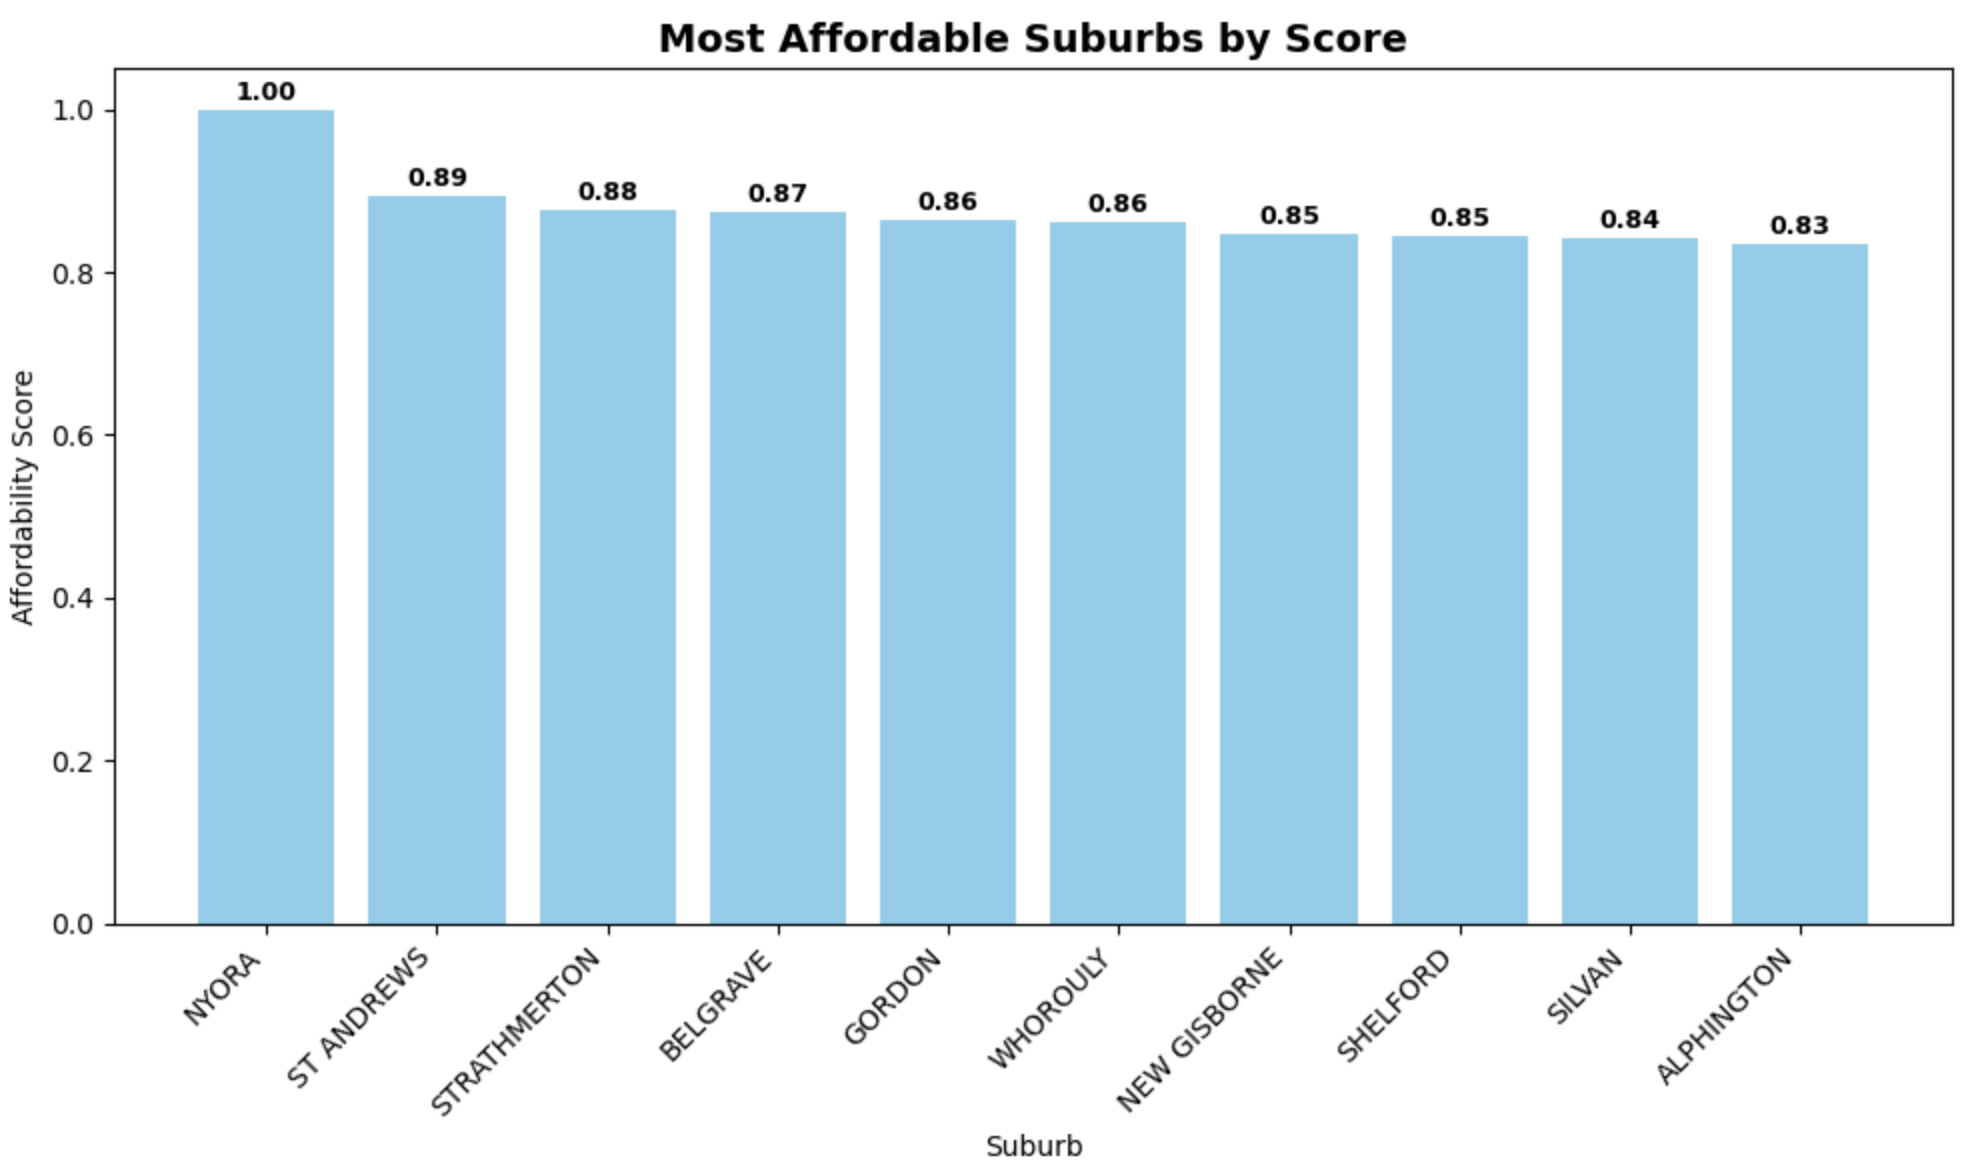


The bar chart below shows 10 subrubs with highest livability score. 

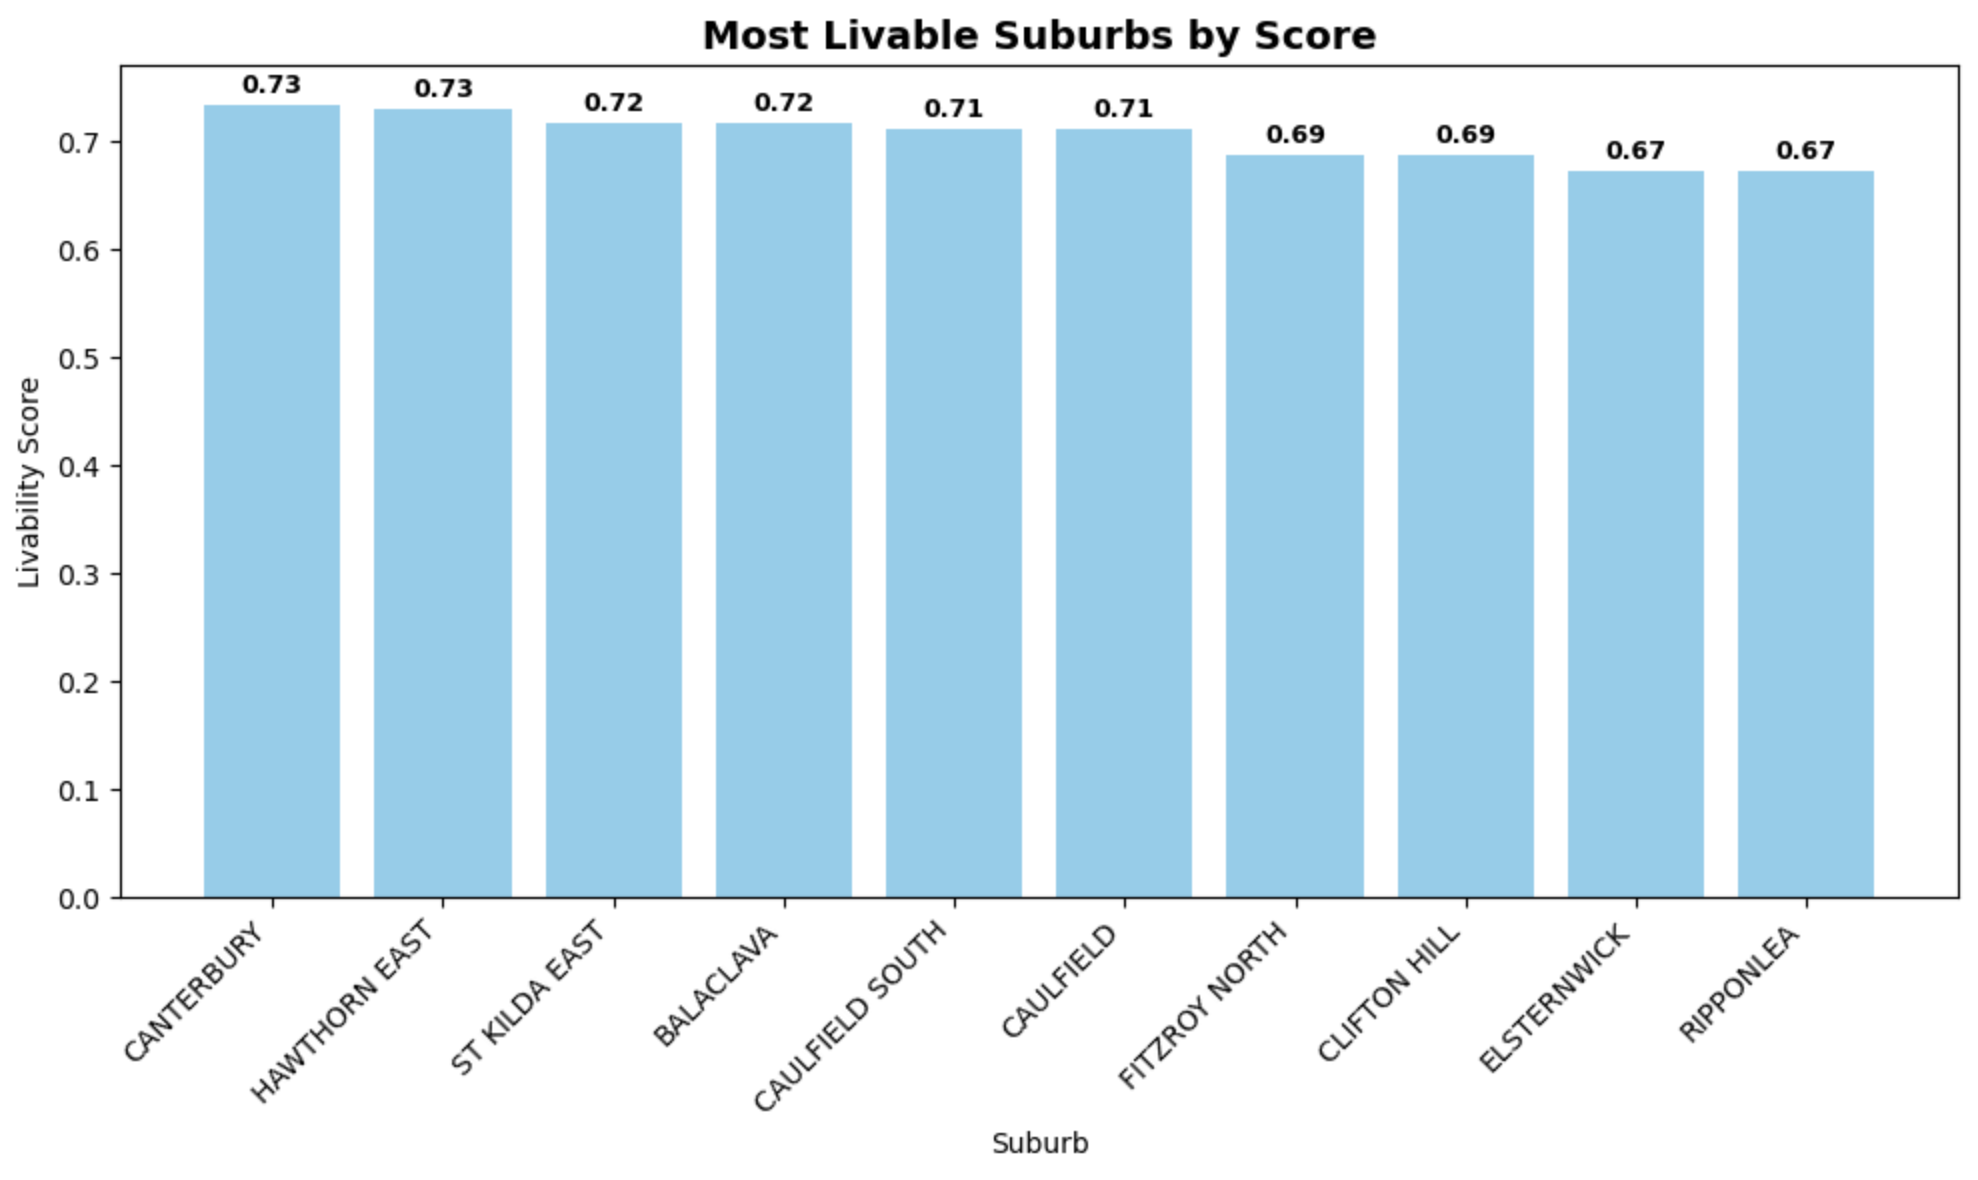


## 6. Rent Forecasting
The model we incorporated for rent forecasting was a time series model using Auto ARIMA, designed to capture seasonal trends in quarterly rental data from 2000 to 2024. Each suburb and property type was modeled separately to account for local variations in rental dynamics. The model produced five-year forecasts (2025–2029), allowing us to estimate future rent trajectories across different property categories. The results highlight that 2-bedroom houses and flats were the most predictable, while larger properties such as 3- and 4-bedroom dwellings showed greater volatility, likely reflecting lower transaction volumes and higher sensitivity to economic fluctuations. The suburb with the largest increase in predicted growth is Mildura while the lowest is Clayton



### Findings 

Our model allowed as to forecast weekly rental price for each quarter of the next 5 years. When we ran the model on validation set with historical data it resulted in accuracy of 94-97 % which is satisfactory. 

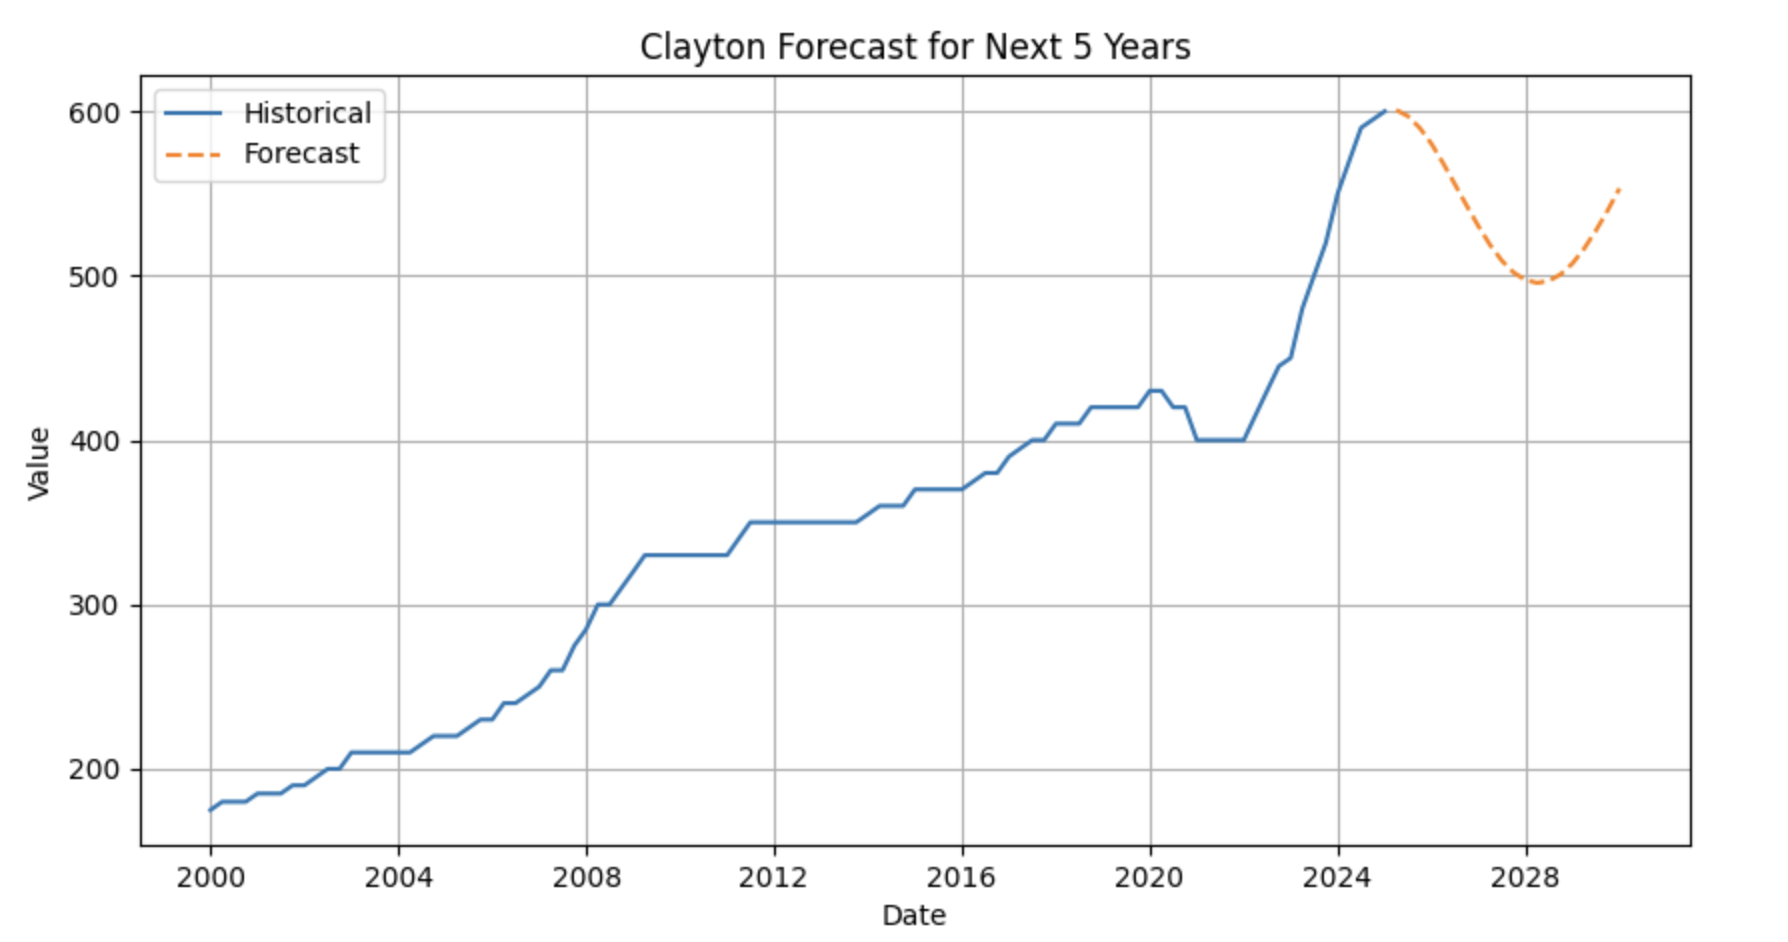

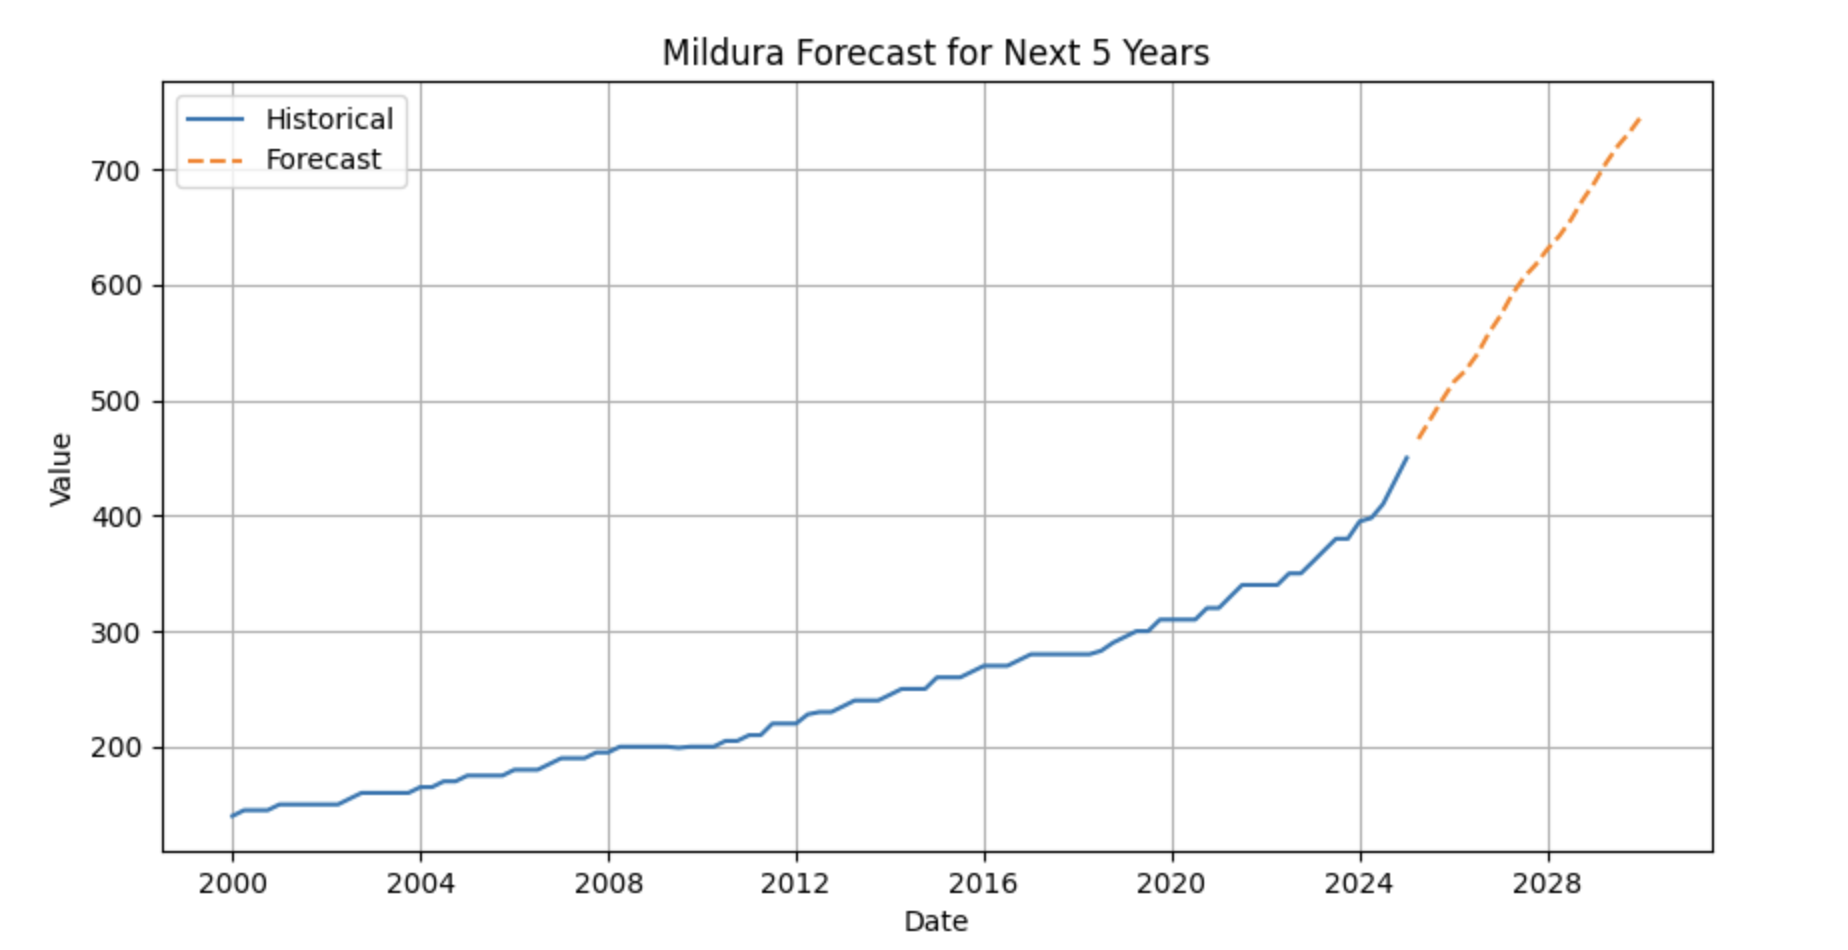



### Below is an analysis of our predictions, divided into sections:

1. Average growth of rental prices by suburbs, first on the overall level and then computed for both only houses and only apartments

Average growth is calculated as 
**[avg(future rent prices) - latest historical rent price / latest historical rent price]**

Below are bar charts showing 10 suburbs with highest predicted rental price increase: overall, only houses, only apartments.

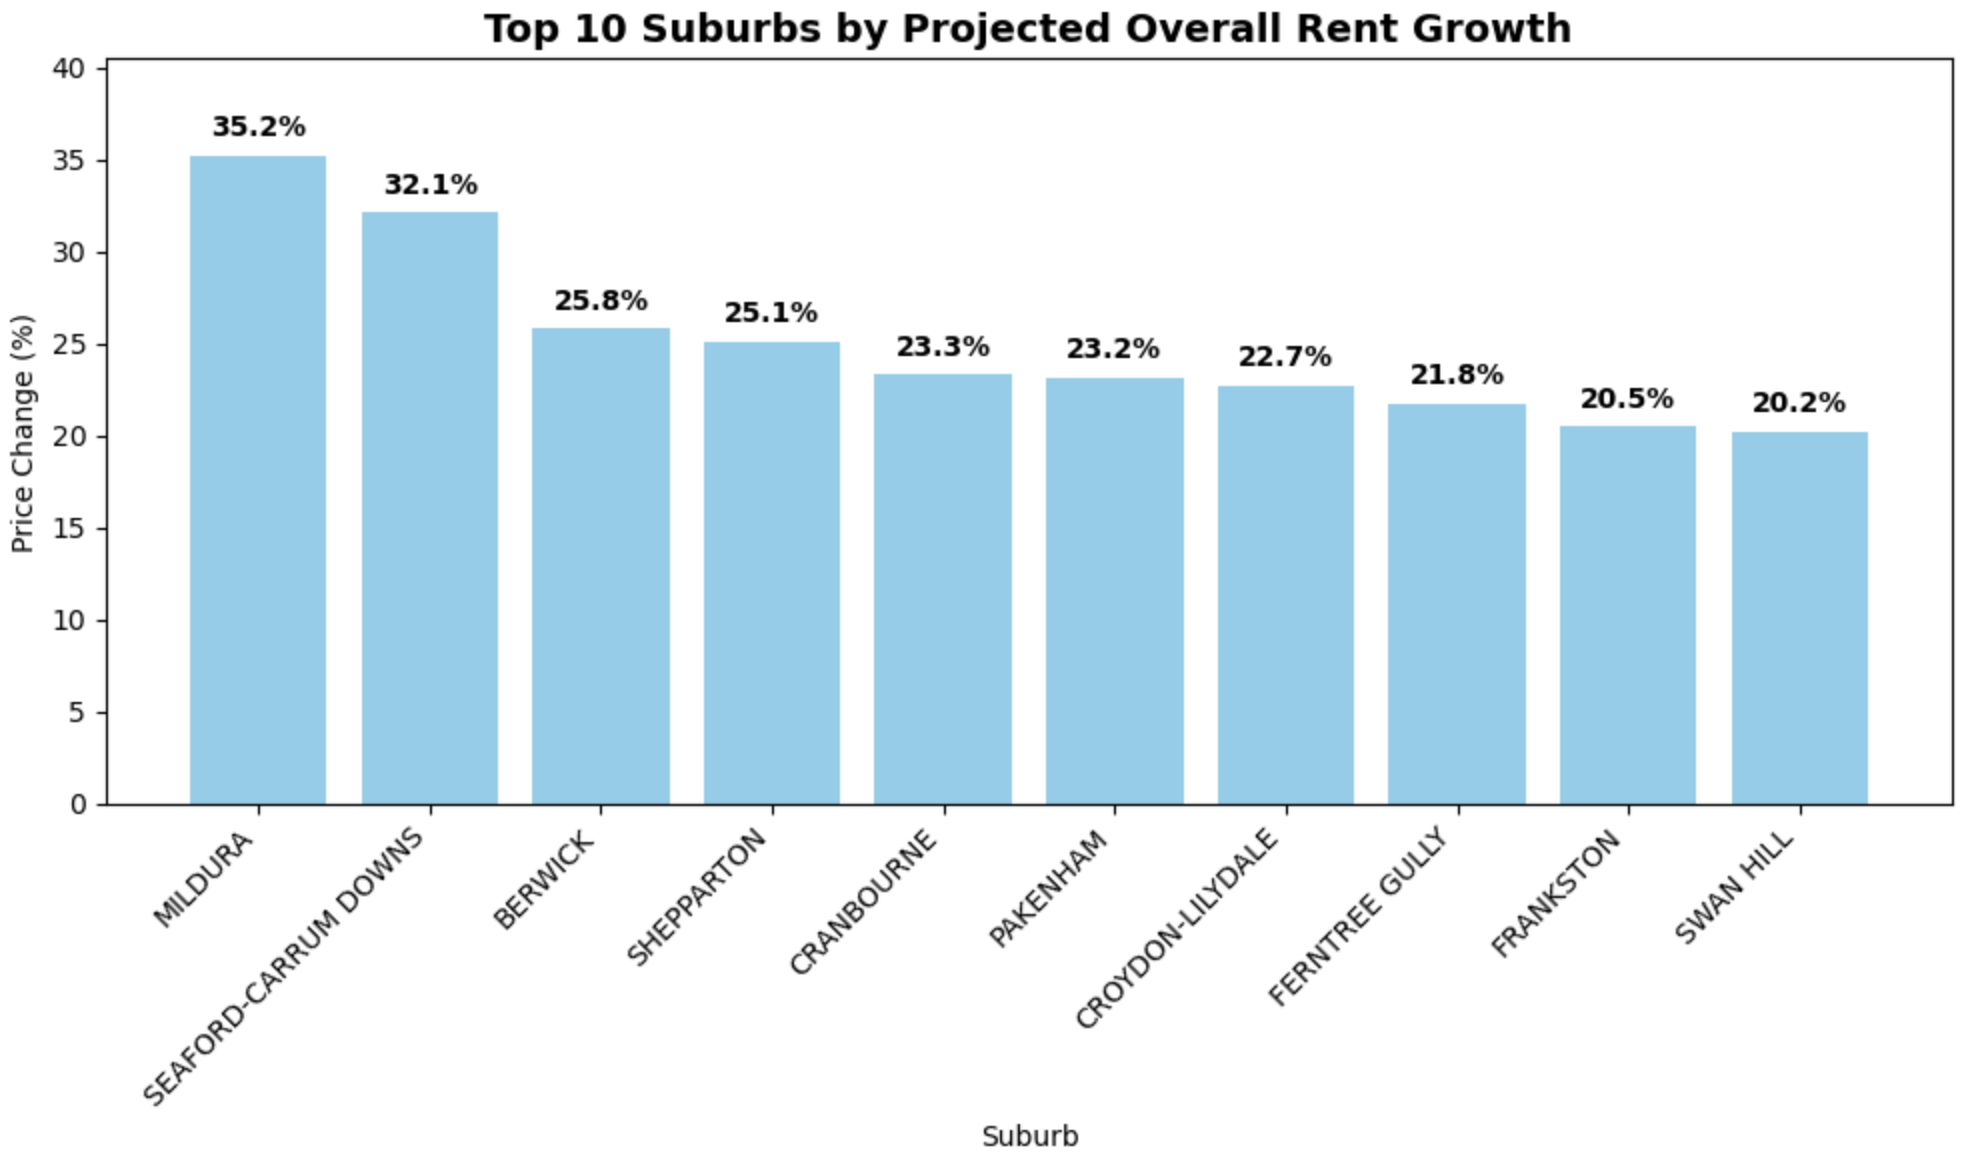

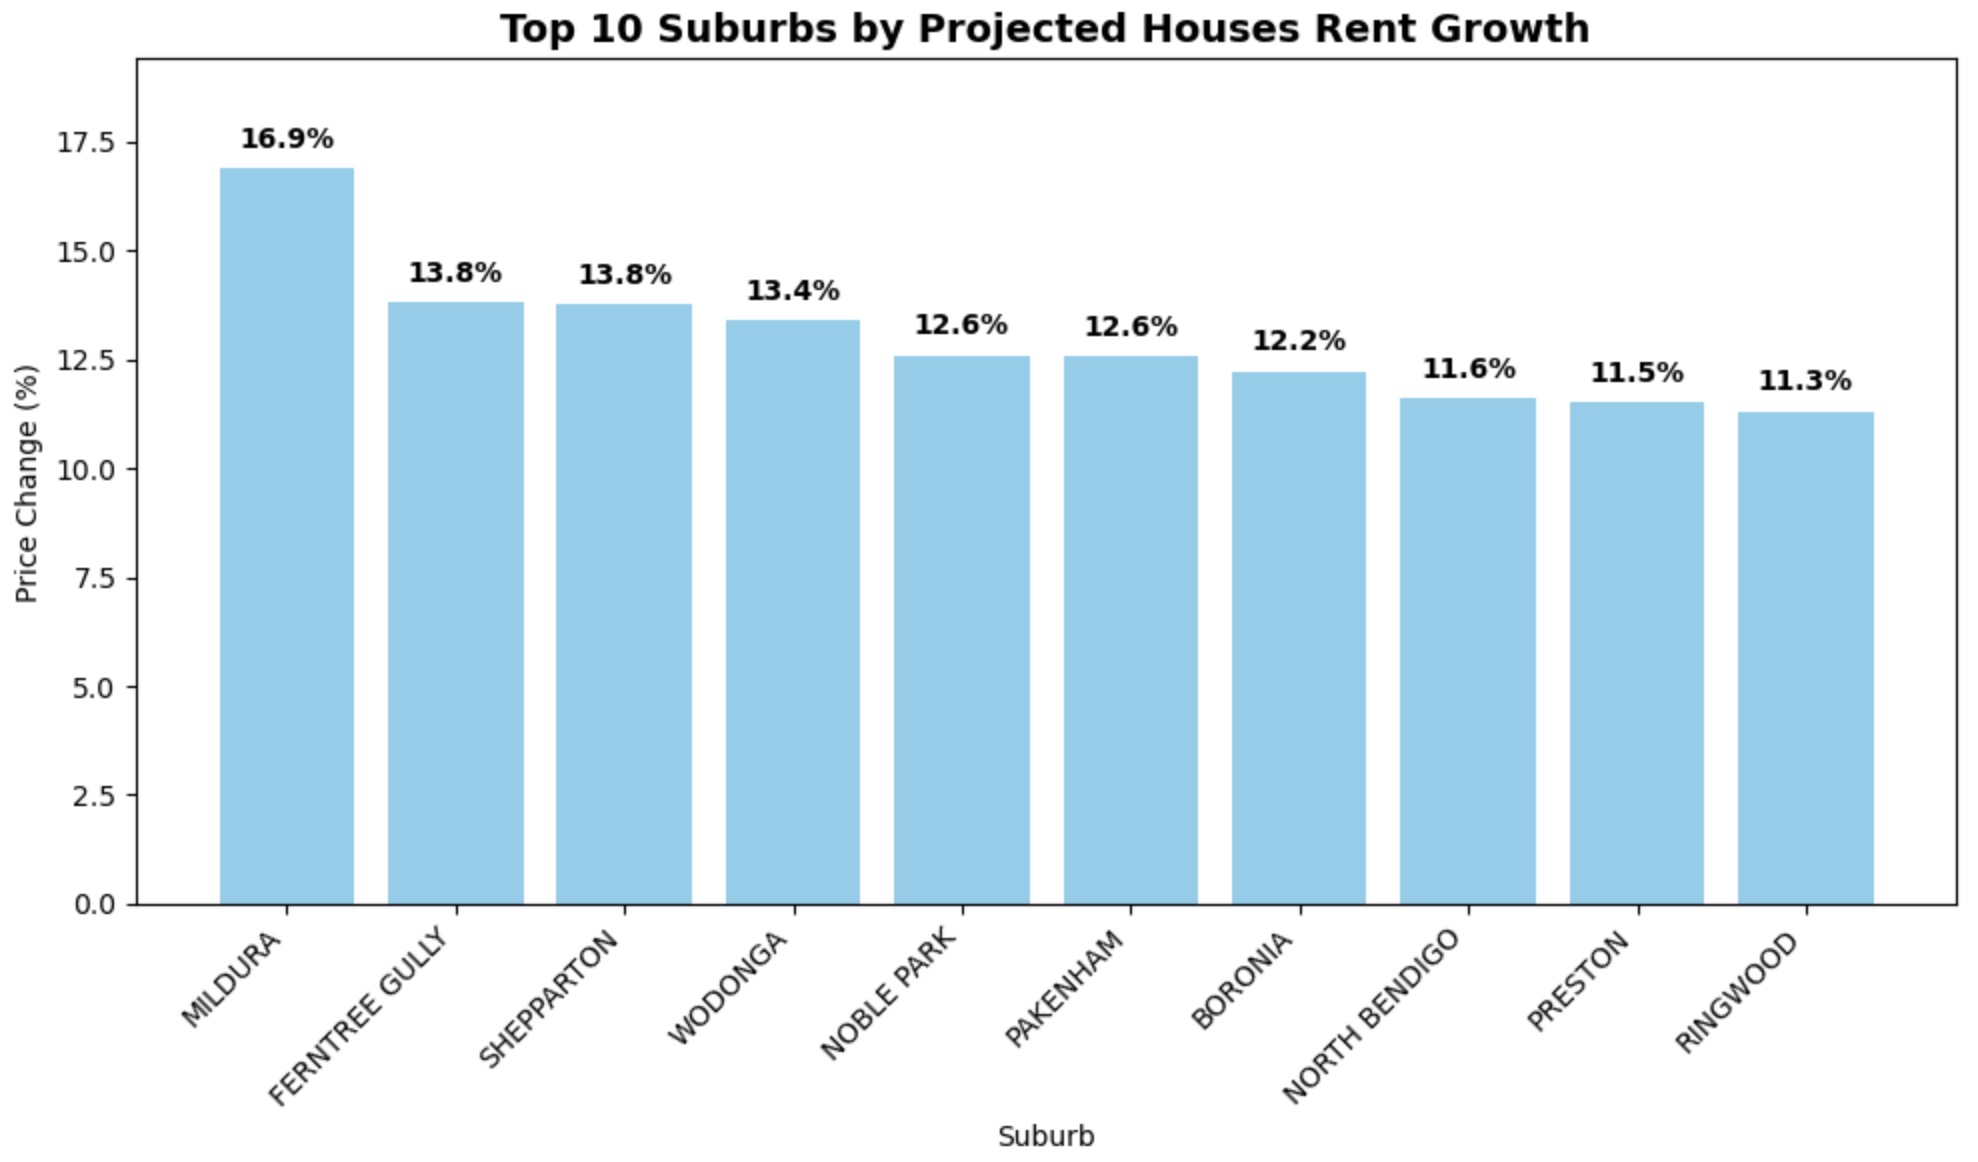

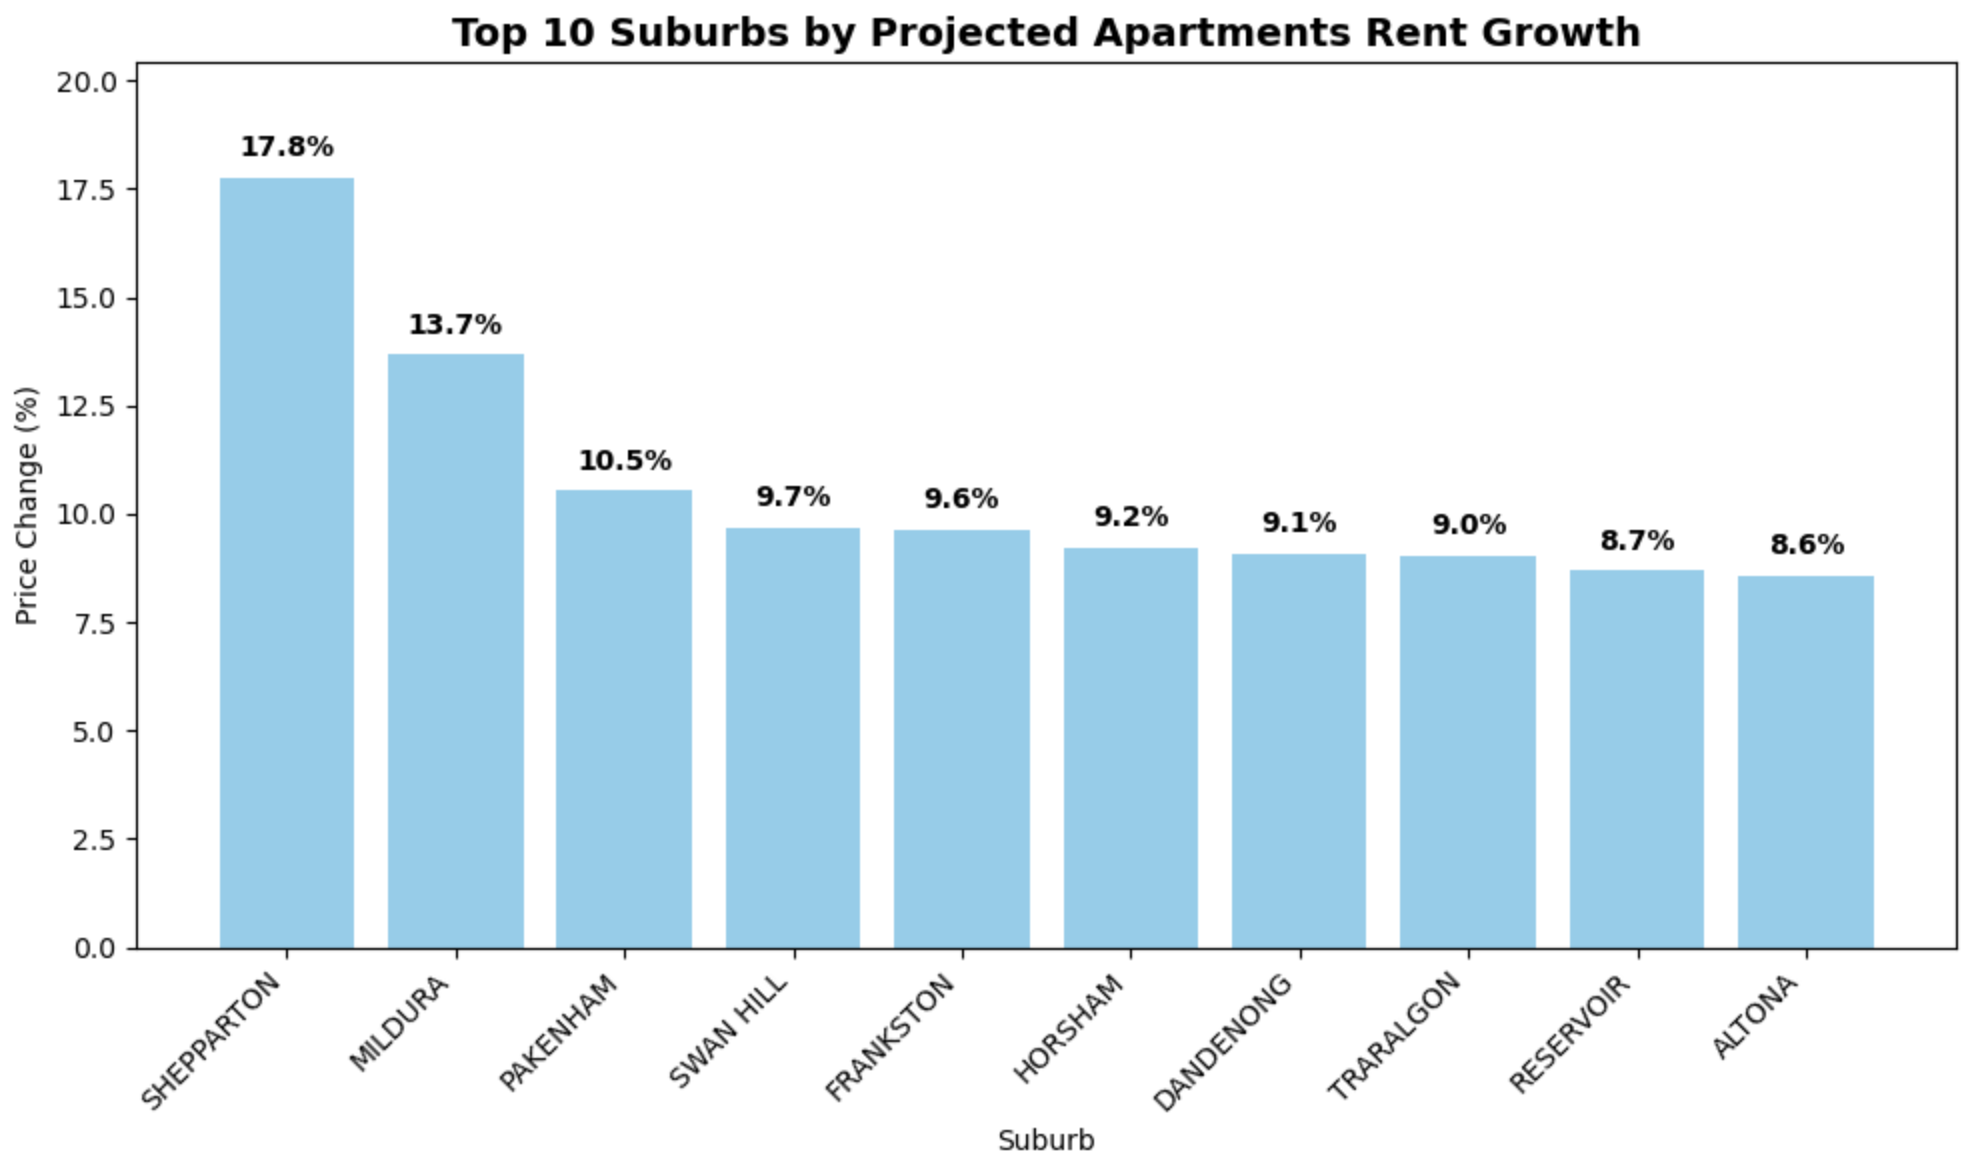


Below are graphs showing similar analysis but for bottom 10 subrubs.

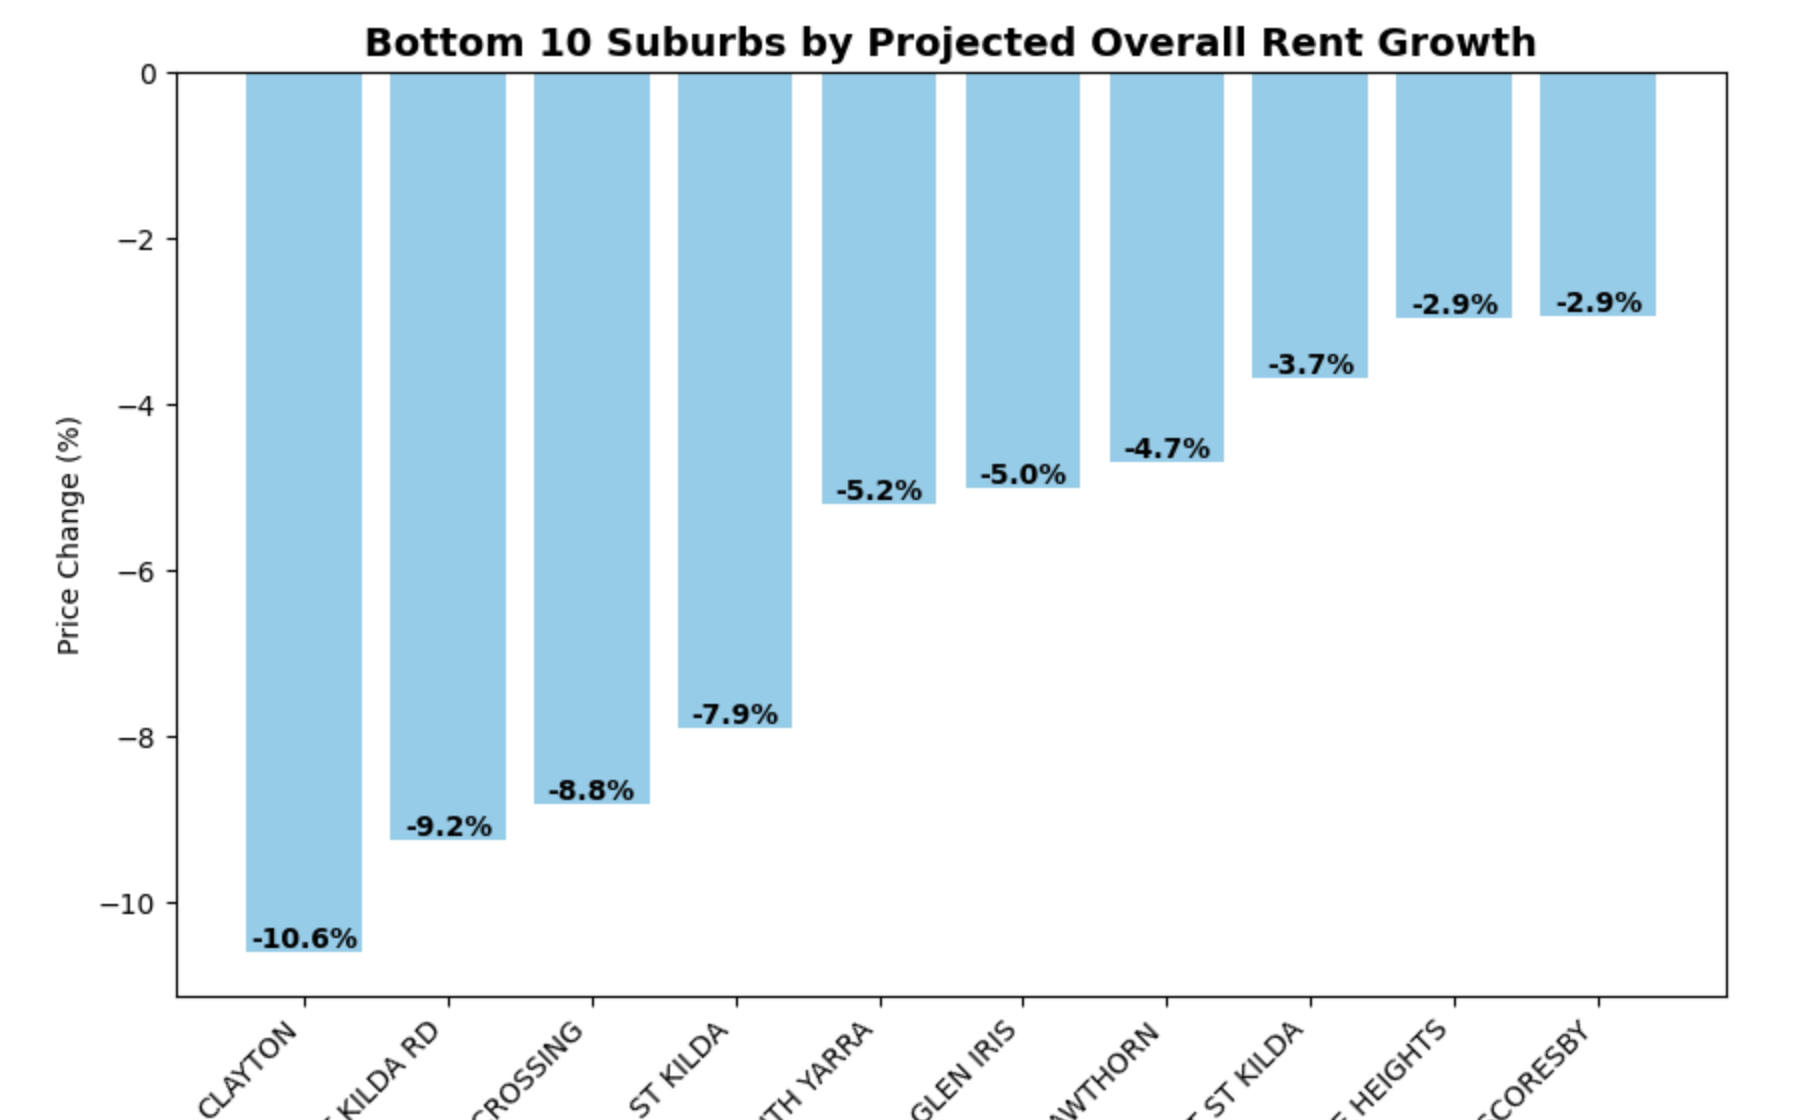

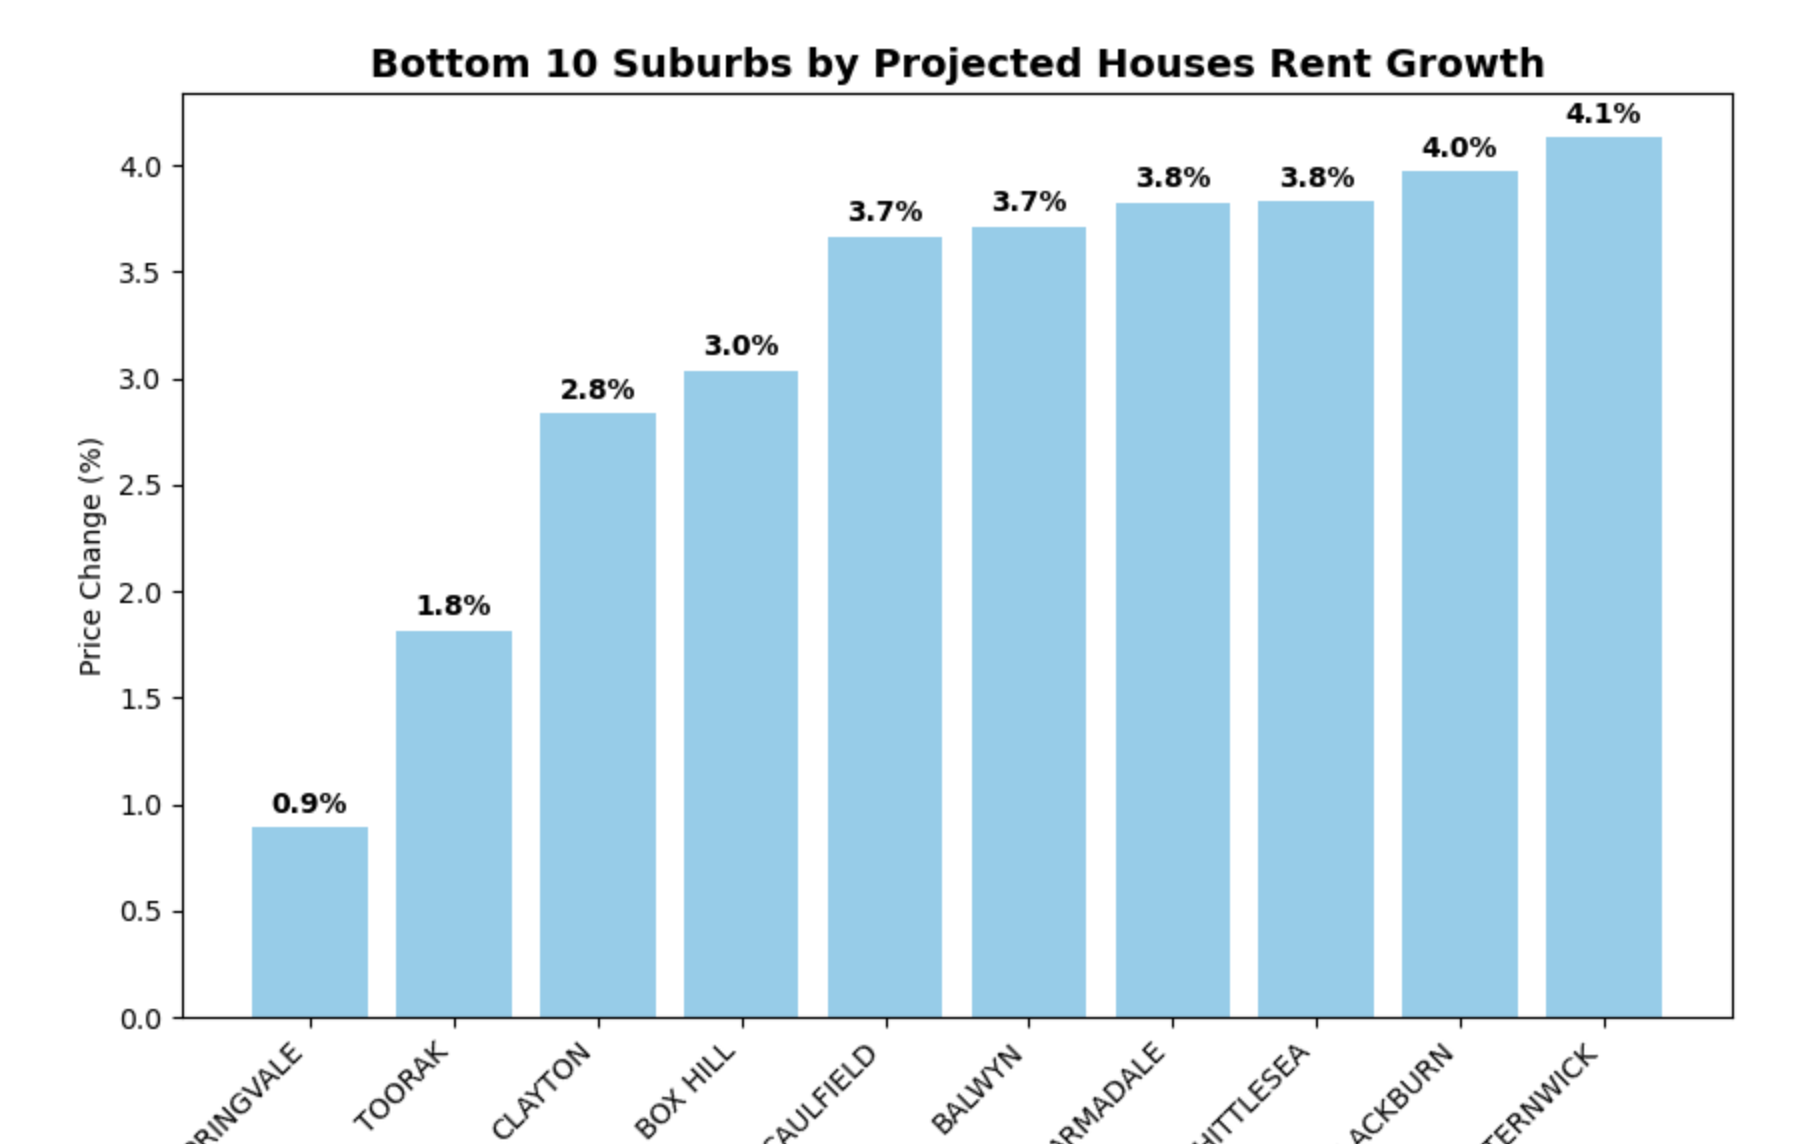

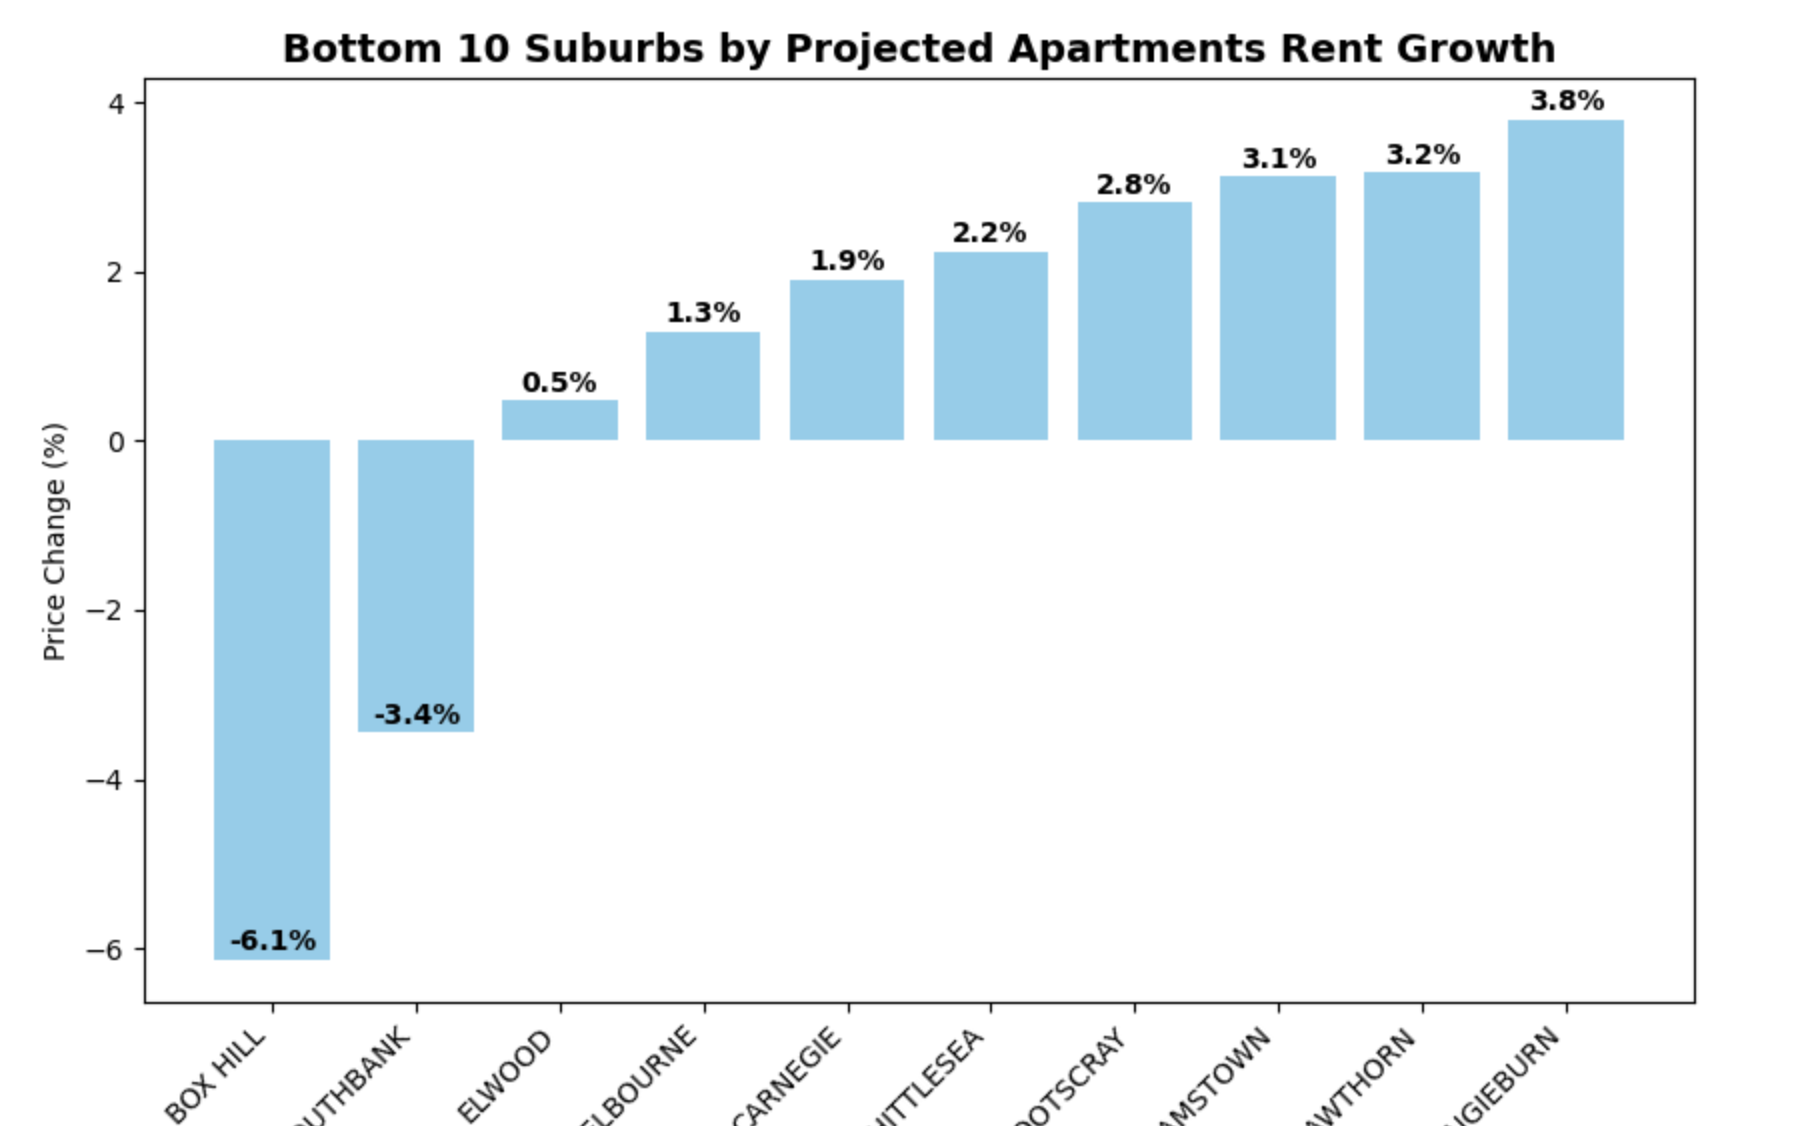

2. Return on Investment analysis done by including current property prices for houses and apartments (extracted from the Victorian
goverment website). Question that we're answering here is: 

### What property type (house/apartment) and in which suburb should I buy to maximize my return on investment (ROI)? 

ROI is calculated as average rental income over next 5 years divided by the median property price today. 

We're limited by the property price data which includes only median prices on the suburb level. Therefore we can't analyze based 
on the number of bedrooms and have to stay with the house/unit granularity.

The bar chart below shows the 5 investments (property type & subrub) with the highest 5 year return on investemnt. 

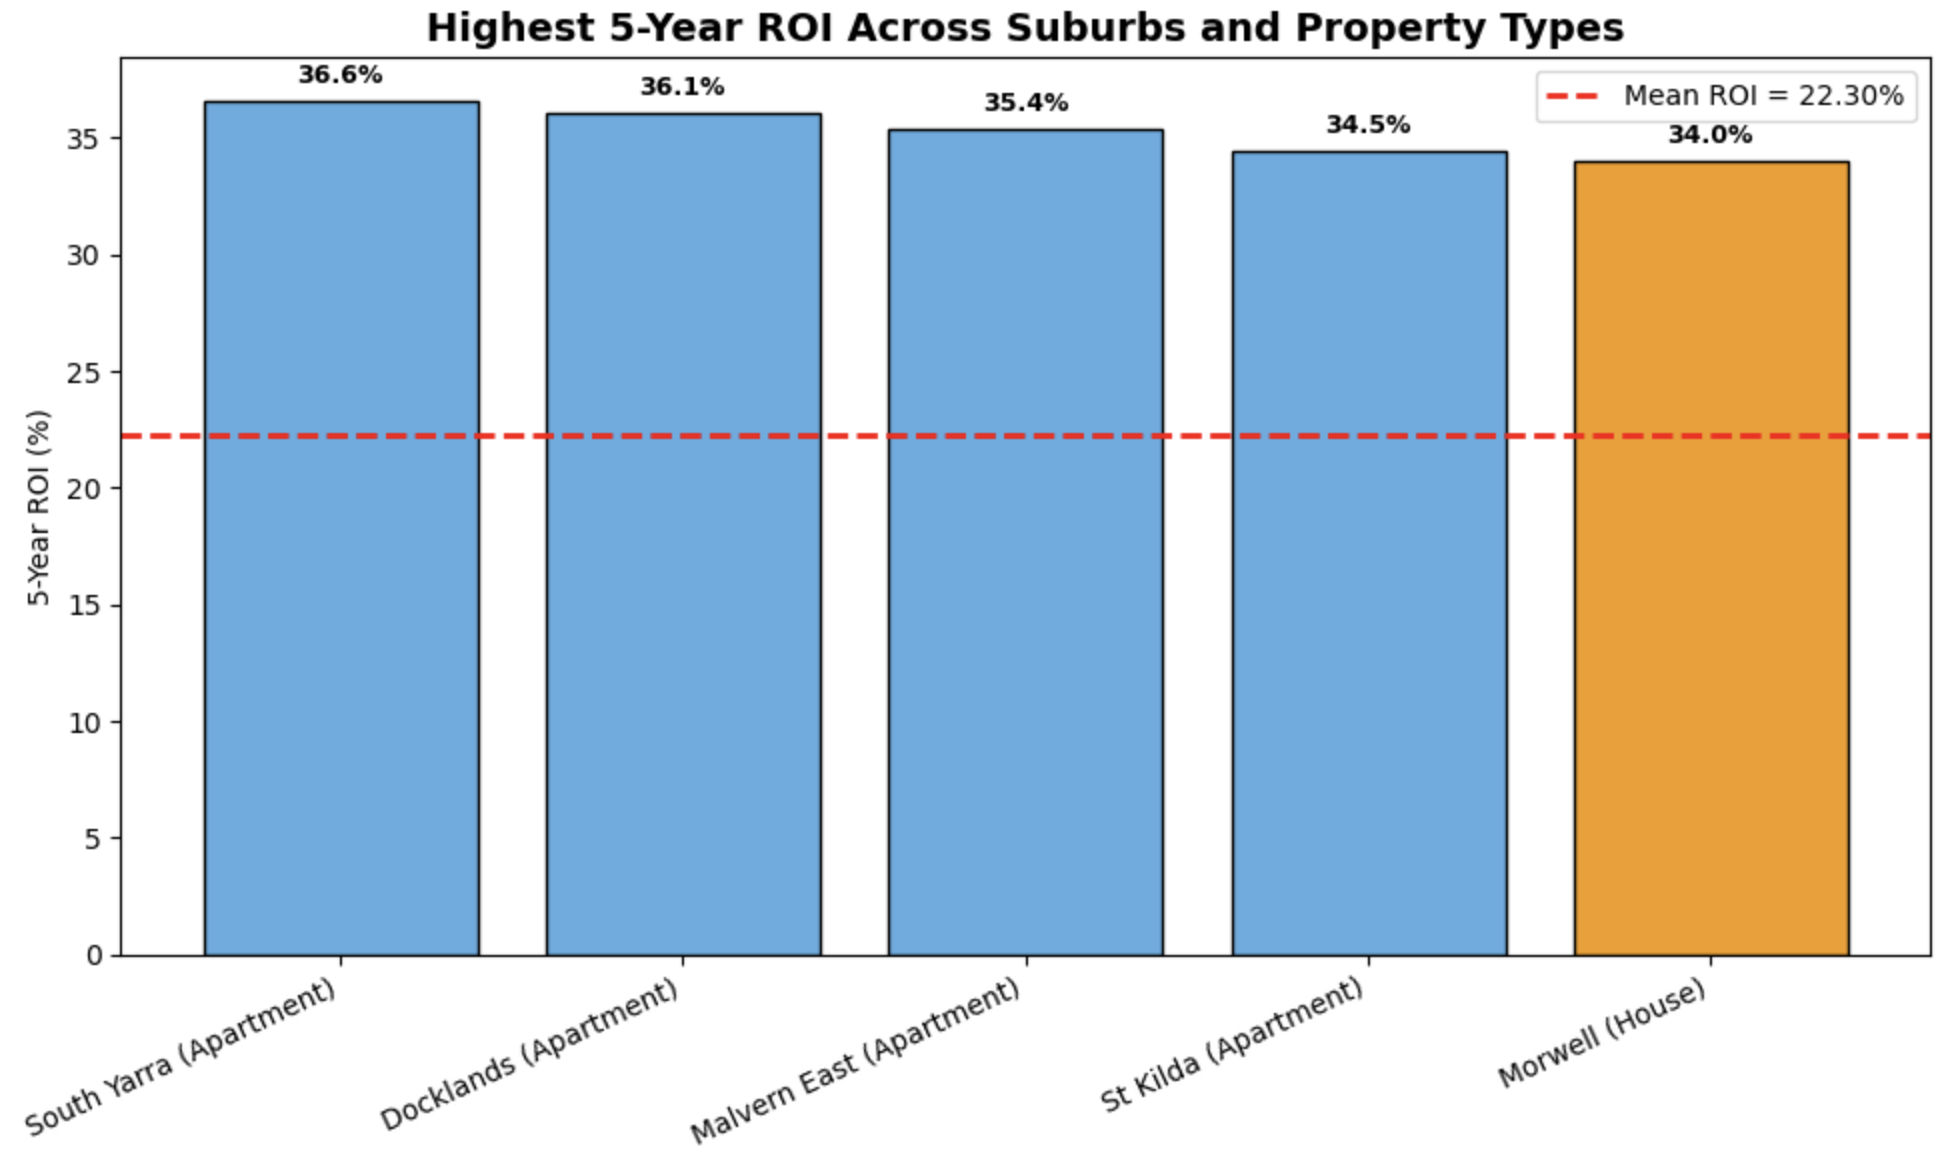

## 7. Overall Limitations

- Temporal mismatches in rental prices: Rental data reflects current listings, while external datasets (e.g., census and population) are lagging indicators

- Sample bias: Scraped domain.com.au dataset may not be representative of the Victorian rental market

- Correlation or causation (even though causation) for feature importance when determining rental prices

## 8. Product Demo: Live Integrated Dashboards

The dashboard is too large to display here, please run final_results.ipynb and open map.html in browser to view.

Essentially, this demo product integrates our key analysis across metrics indicative of: Rental desirability, Affordability, Liveability, Future Growth.

Currently, these are visualised independently, as it would not make sense to aggregate these 4 drivers into a single index since they measure different things.

However, according to clients needs, can easily accomplish this by creating a weighted linear combination of the 4 factors.
For example, if a client/investor priorities future growth, then possibly weight desirability = 0.1, affordability=0.2, liveability=0.2, future growth=0.5. This results in a much neater dashboard where there is no need for multiple layers but rather a single view tailored to the client's needs.

As such, since we don't know what priorities potential investors have, the dashboard currently visualises each factor independently.

A static screenshot for reference:
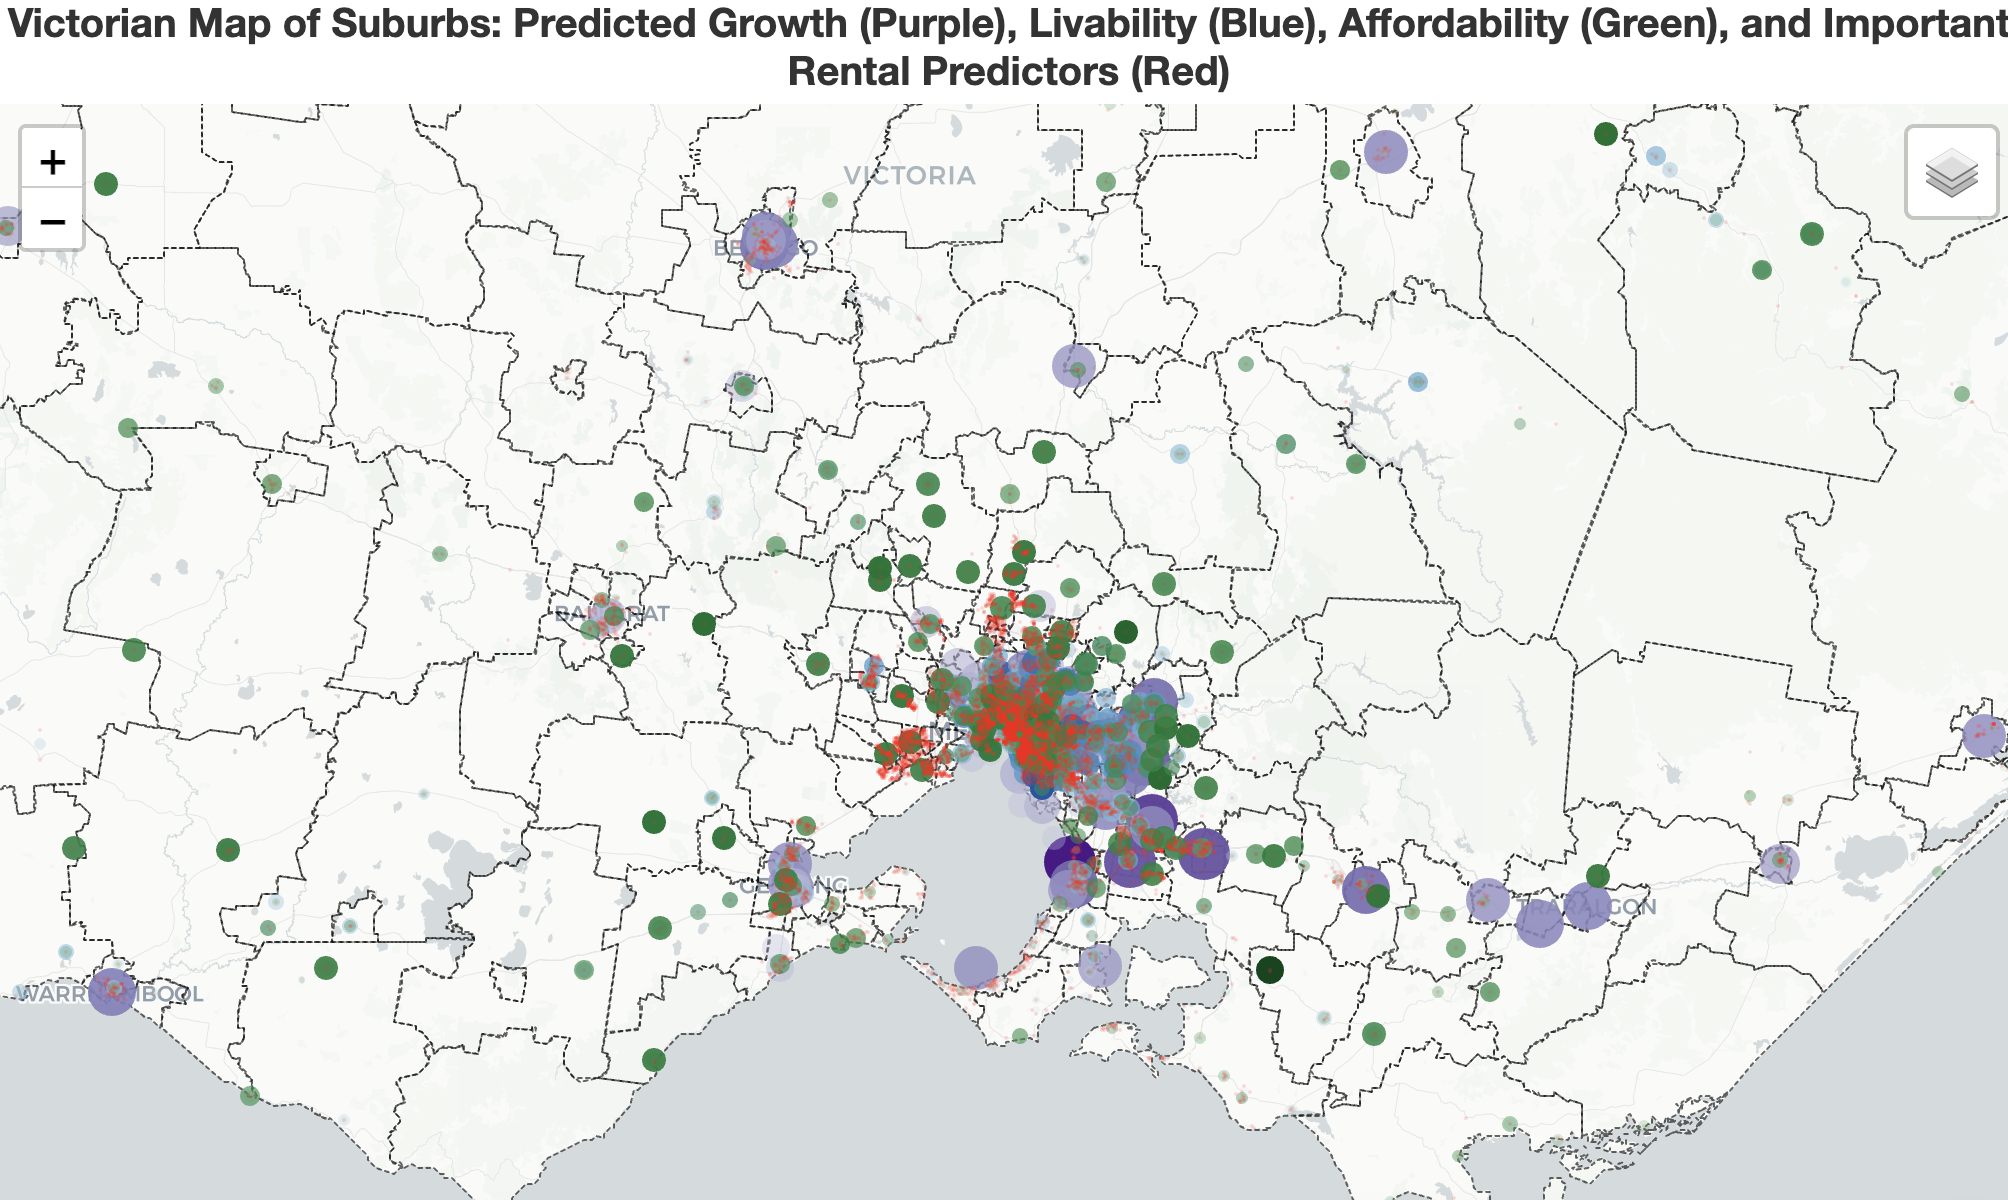